# Probabilistic Graphical Models as a Cybersecurity Tool

# Abstract 

This project is a small subset of tool application from the Georgetown Data Science and Analytics 5650 Computational Social Science course. It investigates how Probabilistic Graphical Models (PGMs) can be used not only for associational reasoning but as a first step toward causal inference in cybersecurity risk modeling. Using Bayesian networks and Markov chains, a simple use case demonstrates a simplified password guessing attack that operates through timing delays or error messages. Through Python simulations and the pgmpy library, we model the operative "attack" and visualization of probability to represent a more general appraoch to probabalistic attack surface management. Treating cyber vulnerabilities probabilistically and dynamically instead of deterministically is a proactive approach to managing cyber threats. 

Ultimately, this work illustrates how tools from computational social science can make cybersecurity systems more transparent and intelligible by modeling risk propagation, adversarial learning, and belief updates in a formal structure. Beyond the academic exercise, the approach could inform a "live" framework for managing cyber threats under uncertainty—bridging simulation, inference, and real-world decision-making.

# Introduction 

Cybersecurity threats are increasingly probabilistic, adaptive, and opaque. Attackers often rely on incomplete information, indirect signals, and iterative strategies: traits that can be captured by Probabilistic Graphical Models (PGMs), which offer a formalism for reasoning under uncertainty. PGMs, particularly Bayesian networks and Markov chains, enable compact representations of conditional dependencies and dynamic state transitions [@koller2009probabilistic].

In this project, we simulate a password guessing attack that leverages system feedback. Inspired by side-channel attack scenarios [@kocher1996timing], we use this toy model to explore how probabilistic inference can reconstruct hidden system states over time. The simulation incorporates both a prior belief over possible characters and a likelihood model informed by empirical or simulated timing data. We then encode the attacker’s belief update process as a Bayesian network using the pgmpy library, allowing for visualization and inference.

The project’s goal is twofold: (1) to model the adversarial learning process using formal tools from computational social science, and (2) to demonstrate how decision-relevant uncertainty evolves as attackers interact with system defenses. This mirrors the approach in Risk Assessment and Decision Analysis with Bayesian Networks [@fenton2018risk], which emphasizes real-world applications of PGMs for decision-making under uncertainty. Unlike traditional deterministic risk models, this probabilistic framework can be closer to a "real-time" risk management response where updated beliefs are modeled using a formal framework. 

By integrating simulation, graphical modeling, and Bayesian reasoning, this work contributes to the study of socio-technical risk systems and supports a reproducible, modular approach to reasoning about adversarial behavior.

# Demonstration

We start with one of the simplest possible cybersecurity tasks, a password hack. Many beginner applications contain login checks similar to this code: 

In [11]:
def insecure_check(user_input):
    secret = "hunter2"
    for i in range(len(user_input)):
        if i >= len(secret) or user_input[i] != secret[i]:
            return False
    return len(user_input) == len(secret)

In this code, if the first character is wrong, it returns immediately. If the first character is right, it moves to the second (etc.). 

This is a constant-time comparison. It is easy to implement insecurely, and easier to break in code that does not implement similar checks properly. Below is a sample script that measures the time it takes to check correct inputs - the timing for the system to check 'incorrect' versus 'correct' inputs is different, by monitoring those time deltas you can confirm that password characters are correct during entry before pressing "enter" to test the password input. 

## Pure Binary Timing Attack 

In [12]:
import time

def test_guess(password_guess):
    start = time.perf_counter()
    insecure_check(password_guess)
    end = time.perf_counter()
    return end - start


By systematically trying all letters for each position and measuring response time, you can build the password one character at a time. This is why secure code uses constant-time comparison functions like:

In [3]:
# import hmac
# hmac.compare_digest(user_input, secret)

# Password Guesser 
## Timing Model

We can represent this as a Bayesian Network or a Markov model, where each character guess is a node whose probability of correctness increases with the time it takes to reject the input. The underlying idea is that the longer the check takes, the more characters are likely to be correct. 

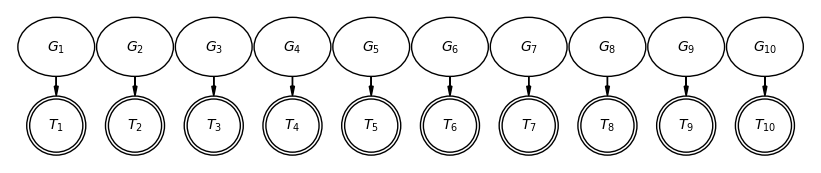

In [4]:
from timing_plot import plot_pgm
plot_pgm()

Bear with me through this example - this example, as demonstrated by the PGM above, makes it visually clear that each password component is considered separately. Each character, G, is guessed and then fed into a timing response loop, T. These help us to generate the predicted posterior, or likelihood of whether or not the binary character 0 or 1 is correct. 

In [5]:
from timing_model import (
    collect_timing_data,
    bin_timings,
    build_model,
    run_inference,
    suggest_password_guess,
    demo_timing_attack
)

# Quick demo
posteriors = demo_timing_attack("hunter2xyz")

# Or step by step
timings = collect_timing_data()
timing_classes = bin_timings(timings)
model = build_model()
posteriors = run_inference(model, timing_classes)
guess = suggest_password_guess(posteriors)
print(f"Binary guess: {guess}")

/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/envs/hack_demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running timing attack demo on secret: hunter2xyz
Timing bins: [0, 0, 0, 1, 1, 1, 2, 2, 2, 2]
(0=short, 1=medium, 2=long)

Building model and running inference...

Results:
Position | P(Correct) | Actual
-----------------------------------
    1    |   0.125    |   h
    2    |   0.125    |   u
    3    |   0.125    |   n
    4    |   0.600    |   t
    5    |   0.600    |   e
    6    |   0.600    |   r
    7    |   0.857    |   2
    8    |   0.857    |   x
    9    |   0.857    |   y
   10    |   0.857    |   z

Suggested binary guess: 0001111111
(1 = likely correct, 0 = likely incorrect)
Binary guess: 0001111111


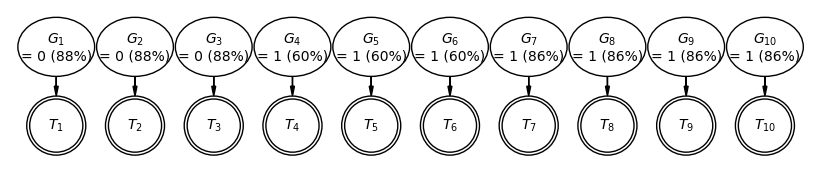

In [8]:
from timing_plot import plot_pgm
plot_pgm(posteriors)

Each node labeled G₁ through G₁₀ represents a latent variable indicating the true bit (0 or 1) at each position in the guessed password. The added annotation (e.g., = 0 (60%)) indicates the most probable value inferred for that variable, based on observed timing feedback. The percentage shows the model's confidence in that guess — in this example, G₄ = 0 (60%) means the model predicts the fourth bit is likely 0, with 60% posterior probability. This probabilistic interpretation is important because it captures the uncertainty in each inference step and can be used to adaptively refine guesses in future attack iterations. 

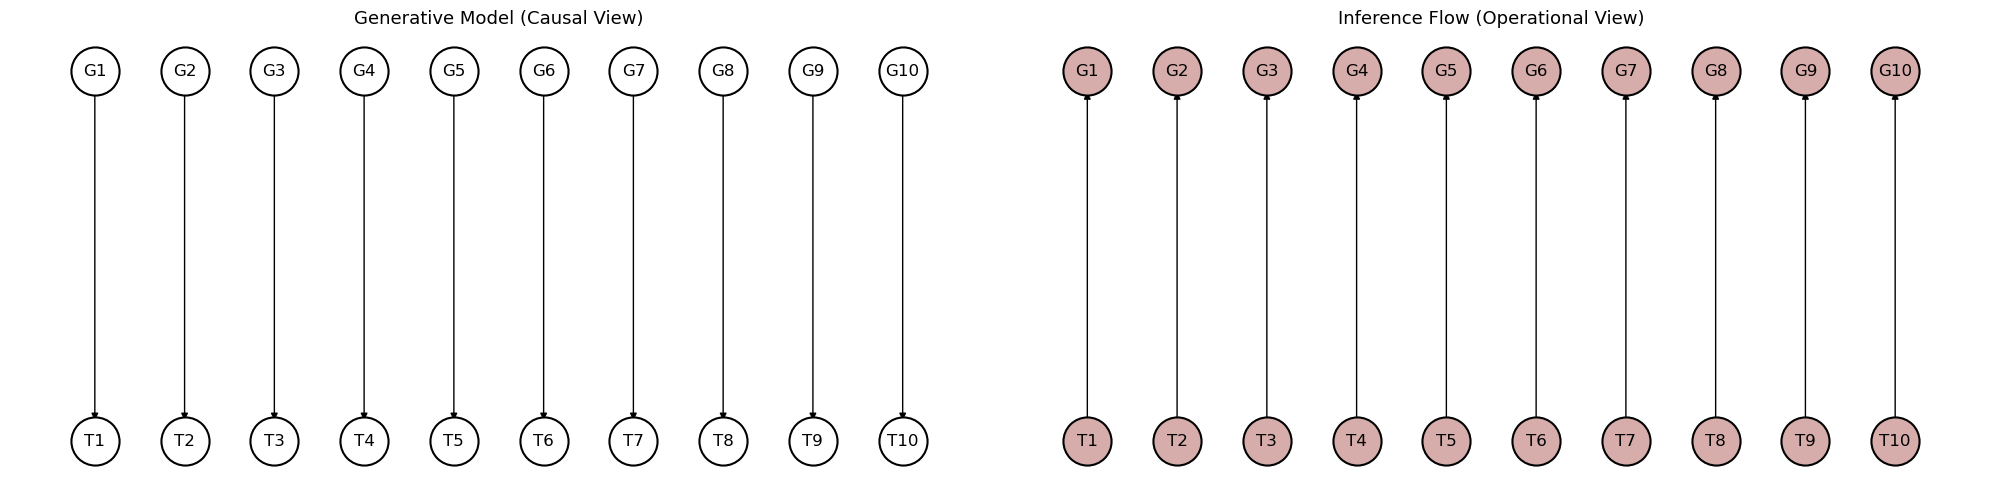

In [9]:
from timing_plot import plot_dual_pgm_views
plot_dual_pgm_views()


These results are pretty simple. The probabilities based on this basic code don't really give us a lot of confidence when we examine the suggested entry for the password check, do they? To try and provide something a little more realistic, we'll try another iteration using the PGM models to think about how we might show something more useful. Let's first include all lowercase letters, capital letters, 0-9, and special characters !@#$%^&* in our ten entry password guesser. It will also make more sense to try and update the next 'guess' based on what the previous timing response was. 

## Characters, and prior entry | Worldlike Model

In [10]:
from wordlike_plot import plot_wordlike_pgm
plot_wordlike_pgm(use_ngrams=True) # Plot with trigram support

Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt


NameError: name 'CHARSET' is not defined

In [ ]:
from wordlike_model import build_wordlike_model, run_word_inference, suggest_wordlike_guess, CHARSET_INDEX

# Automatically uses large dataset (5000 words)
model = build_wordlike_model(use_ngrams=True)

# Test with vegetable
observed = {
    "G1": CHARSET_INDEX['v'],
    "G2": CHARSET_INDEX['e'],
    "G3": CHARSET_INDEX['g']
}

posteriors = run_word_inference(model, observed)
best_guess = suggest_wordlike_guess(posteriors, observed)
print(f"Suggested guess: {best_guess}")

Suggested guess: vegetableo


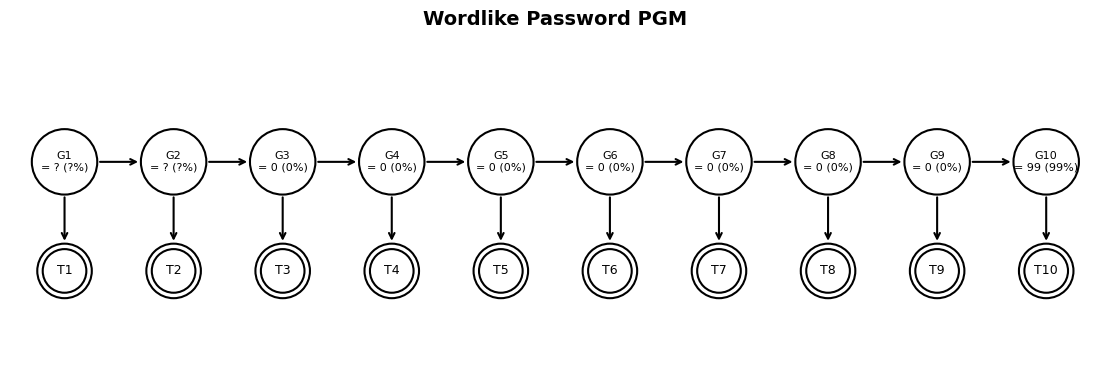

In [ ]:
from wordlike_plot import plot_wordlike_pgm_nx 
model = build_wordlike_model(use_ngrams=True)
observed = {"G1": CHARSET_INDEX["v"], "G2": CHARSET_INDEX["e"]}
posteriors = run_word_inference(model, observed)

plot_wordlike_pgm_nx(posteriors=posteriors)


## Password Guessing with Both Timing and Typing Dynamics | Hybrid Model

Now, to integrate the prior guess probabilities from the word model (wordlike_model) and the likelihood from timing data (timing_model).

In [ ]:
import numpy as np

def build_timing_cpd():
    """
    Returns a list-of-lists representing P(T_i | G_i) with shape (3, len(CHARSET))
    - Row 0: P(T=short | G)
    - Row 1: P(T=med   | G)
    - Row 2: P(T=long  | G)
    """
    len_charset = len(CHARSET)

    # Example: assume guesses that are more correct produce longer times
    # We'll say even-indexed guesses are "wrong" → short delay
    # and odd-indexed guesses are "right" → long delay
    cpd = np.zeros((len_charset, 3))

    for i in range(len_charset):
        if i % 2 == 0:
            cpd[i] = [0.6, 0.3, 0.1]  # wrong guess
        else:
            cpd[i] = [0.1, 0.3, 0.6]  # right guess

    return cpd.T  # Transpose to shape (3, len(CHARSET))


In [ ]:
from hybrid_model import build_hybrid_model, run_hybrid_inference
from wordlike_model import CHARSET
from timing_model import bin_timings, collect_timing_data
from wordlike_model import suggest_wordlike_guess

words = ["password", "hunter", "welcome", "admin", "vegetable", "dragon", "Monkey123!"]
timing = collect_timing_data("hunter2xyz")  # or real keystroke times
timing_classes = bin_timings(timing)

# Build timing CPD (dummy version for now)
timing_cpd = build_timing_cpd()  # You can calibrate this better later

# Build hybrid model
model = build_hybrid_model(words, timing_cpd)

# Run inference
posteriors = run_hybrid_inference(model, timing_classes)

# Suggest best guess
guess = suggest_wordlike_guess(posteriors)
print("Hybrid Suggested Password:", guess)


Hybrid Suggested Password: assworddb3


That password is actually depressingly realistic. 

## More Realistic Timing / Keystroke Data

The update will collect timing per character guess, then be labeled as correct or incorrect.

* Bin durations (e.g. into short/medium/long).
* Count occurrences of each bin per label.
* Normalize to compute the probably given $P(T_i \mid G_i)$

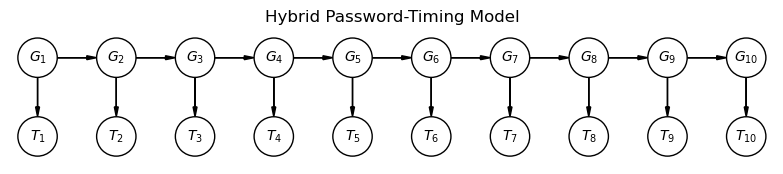

In [ ]:
from hybrid_plot import plot_hybrid_pgm

# For bigram-based character model
plot_hybrid_pgm(use_ngrams=False)

In [ ]:
from hybrid_model import build_hybrid_model, run_hybrid_inference
from wordlike_model import suggest_wordlike_guess, CHARSET
from timing_model import collect_timing_characterwise, simulate_wrong_timings, build_empirical_timing_cpd
import numpy as np

correct = collect_timing_characterwise("hunter2xyz")
incorrect = simulate_wrong_timings("hunter2xyz")

# Build CPD
timing_cpd = np.array(build_empirical_timing_cpd(correct, incorrect)).T  # shape (3, 70)

# Build model and infer
words = ["password", "hunter", "welcome", "admin", "vegetable"]
model = build_hybrid_model(words, timing_cpd)

timing_durations = [t[0] for t in correct]  # or from real data
from timing_model import bin_timings
timing_classes = bin_timings(timing_durations)

posteriors = run_hybrid_inference(model, timing_classes)
guess = suggest_wordlike_guess(posteriors)
print("Empirical hybrid guess:", guess)

Empirical hybrid guess: asswordeer


## Simulated Attack Model 

Now, we'll try to simulate an attack that: 
1. Starts with no knowledge.
2. Probes the system one character at a time.
3. Collects timing feedback after each probe.
4. Updates the PGM and refines guesses at each round.
5. Builds the password one character at a time by combining timing + language model.

In [ ]:
from timing_model import collect_timing_characterwise, simulate_wrong_timings, build_empirical_timing_cpd
from adaptive_attack import simulate_adaptive_attack
from wordlike_model import CHARSET

# Step 1: Gather timing data
correct = collect_timing_characterwise("hunter2xyz")
incorrect = simulate_wrong_timings("hunter2xyz")
timing_cpd = np.array(build_empirical_timing_cpd(correct, incorrect)).T

# Step 2: Simulate attack
words = ["password", "hunter", "welcome", "admin", "vegetable"]
simulate_adaptive_attack("hunter2xyz", words, timing_cpd, use_ngrams=True)


ModuleNotFoundError: No module named 'adaptive_attack'

## From PGM to Dynamic Bayesian Network: 

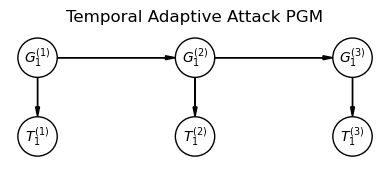

In [ ]:
from adaptive_plot_temporal import plot_temporal_adaptive_pgm
plot_temporal_adaptive_pgm(rounds=3)

Where each node contains a its own PGM. 

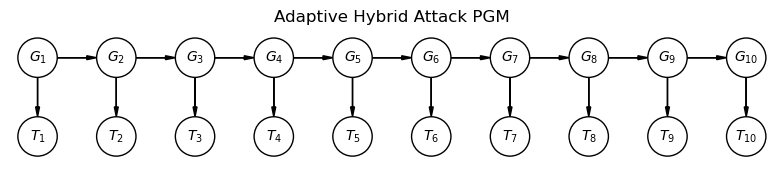

In [ ]:
from adaptive_plot_temporal import plot_adaptive_attack_pgm

# For bigram model
plot_adaptive_attack_pgm(use_ngrams=False)

# Take Two 

In [ ]:
# # Test the module when imported
# if __name__ == "__main__":
#     print("Testing common_words module...")
#     test_words = get_training_words(source="default", limit=10)
#     print(f"Test words: {test_words}")

In [1]:
# Verify all modules are available
import timing_model
import wordlike_model
import hybrid_model
import timing_plot
import wordlike_plot
import hybrid_plot
import common_words
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("All modules loaded successfully!")

/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/envs/hack_demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All modules loaded successfully!


PART 1: TIMING SIDE-CHANNEL ATTACK

Demonstrating how response time reveals password structure
----------------------------------------------------------------------

Target password: Secret123
Password length: 9

1. TIMING ATTACK PGM STRUCTURE
----------------------------------------
Model structure: G_i → T_i
- G_i ∈ {0,1}: Position i is incorrect (0) or correct (1)
- T_i ∈ {0,1,2}: Timing observation (short/medium/long)


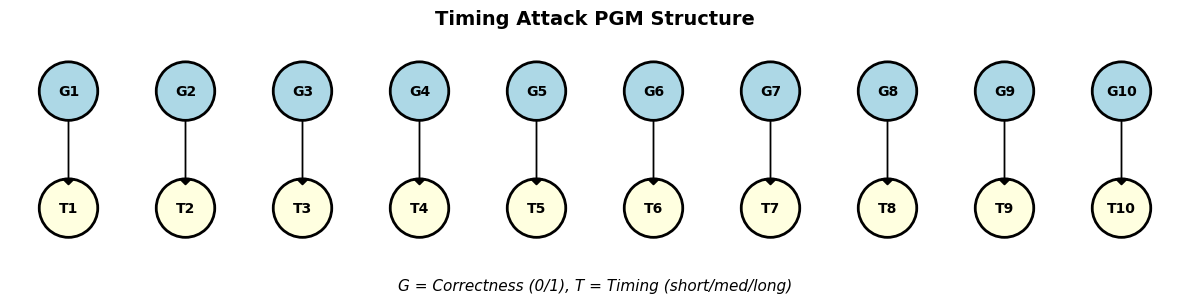


2. COLLECTING TIMING DATA
----------------------------------------
Simulating timing measurements for progressive password guesses...
Raw timings (seconds): ['0.0106', '0.0251', '0.0376', '0.0478', '0.0626', '0.0725', '0.0837', '0.0971', '0.1113']
Timing bins: [0, 0, 1, 1, 1, 2, 2, 2, 2]
Bins: 0=short (wrong), 1=medium, 2=long (correct)


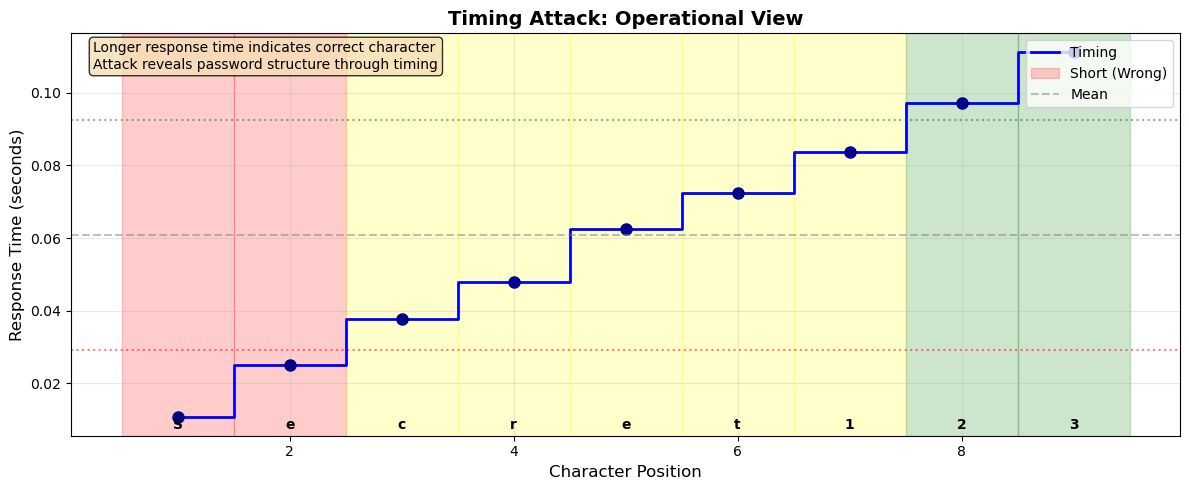


3. RUNNING TIMING INFERENCE
----------------------------------------
Binary prediction: 0011111110
Interpretation: '1' = likely correct position, '0' = likely incorrect


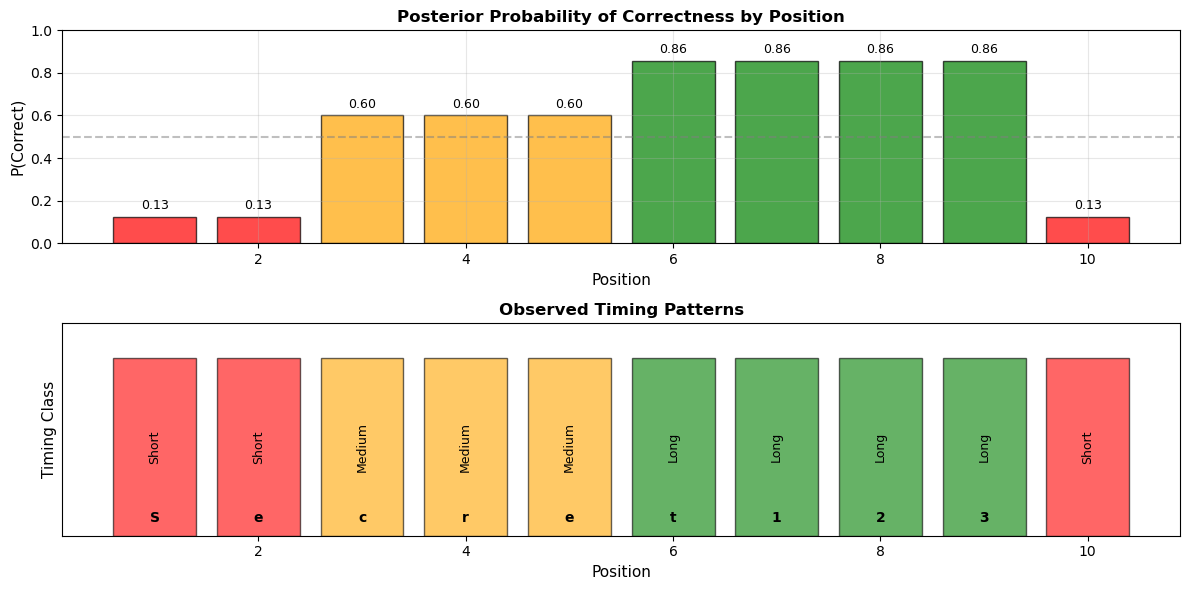


4. TIMING ATTACK SUMMARY
----------------------------------------
Average P(correct): 0.560
Positions with high confidence (P>0.7): 4

Key insight: Timing reveals which positions are correct,
but not the actual characters!


In [ ]:
# ============================================================================
# PART 1: TIMING ATTACK
# ============================================================================

print("=" * 70)
print("PART 1: TIMING SIDE-CHANNEL ATTACK")
print("=" * 70)
print("\nDemonstrating how response time reveals password structure")
print("-" * 70)

# Import timing attack components
from timing_model import (
    build_timing_model,
    collect_timing_data,
    bin_timing_measurements,
    run_timing_inference,
    suggest_binary_guess,
    demo_timing_attack
)
from timing_plot import (
    plot_timing_pgm_structure,
    plot_timing_posteriors,
    plot_timing_operational
)

# Set target password for timing attack
target_password = "Secret123"
print(f"\nTarget password: {target_password}")
print(f"Password length: {len(target_password)}")

# Step 1: Show PGM Structure
print("\n1. TIMING ATTACK PGM STRUCTURE")
print("-" * 40)
print("Model structure: G_i → T_i")
print("- G_i ∈ {0,1}: Position i is incorrect (0) or correct (1)")
print("- T_i ∈ {0,1,2}: Timing observation (short/medium/long)")

fig = plot_timing_pgm_structure(figsize=(12, 4))
plt.show()

# Step 2: Collect Timing Data
print("\n2. COLLECTING TIMING DATA")
print("-" * 40)
print("Simulating timing measurements for progressive password guesses...")

timings = collect_timing_data(target_password)
timing_classes = bin_timing_measurements(timings)

print(f"Raw timings (seconds): {[f'{t:.4f}' for t in timings[:len(target_password)]]}")
print(f"Timing bins: {timing_classes[:len(target_password)]}")
print("Bins: 0=short (wrong), 1=medium, 2=long (correct)")

# Show operational view of timing data
fig = plot_timing_operational(timings[:len(target_password)], 
                             secret=target_password, 
                             figsize=(12, 5))
plt.show()

# Step 3: Run Inference
print("\n3. RUNNING TIMING INFERENCE")
print("-" * 40)

model = build_timing_model()
posteriors = run_timing_inference(model, timing_classes)
binary_guess = suggest_binary_guess(posteriors)

print(f"Binary prediction: {binary_guess}")
print("Interpretation: '1' = likely correct position, '0' = likely incorrect")

# Show posterior probabilities
fig = plot_timing_posteriors(posteriors, 
                            timing_classes=timing_classes,
                            secret=target_password,
                            figsize=(12, 6))
plt.show()

# Summary of timing attack
print("\n4. TIMING ATTACK SUMMARY")
print("-" * 40)
correctness_probs = []
for i in range(1, 11):
    if f"G{i}" in posteriors:
        correctness_probs.append(posteriors[f"G{i}"].values[1])
    else:
        correctness_probs.append(0.5)

print(f"Average P(correct): {np.mean(correctness_probs):.3f}")
print(f"Positions with high confidence (P>0.7): {sum(1 for p in correctness_probs if p > 0.7)}")
print("\nKey insight: Timing reveals which positions are correct,")
print("but not the actual characters!")


PART 2: CHARACTER PREDICTION ATTACK

Using language patterns to predict password characters
----------------------------------------------------------------------

Target password: vegetable
Known prefix: veg

1. CHARACTER PREDICTION PGM STRUCTURE
----------------------------------------
Model structure: G_i-1 → G_i (with optional G_i-2 → G_i)
- G_i ∈ CHARSET: Character at position i
- Uses n-gram language patterns from training data


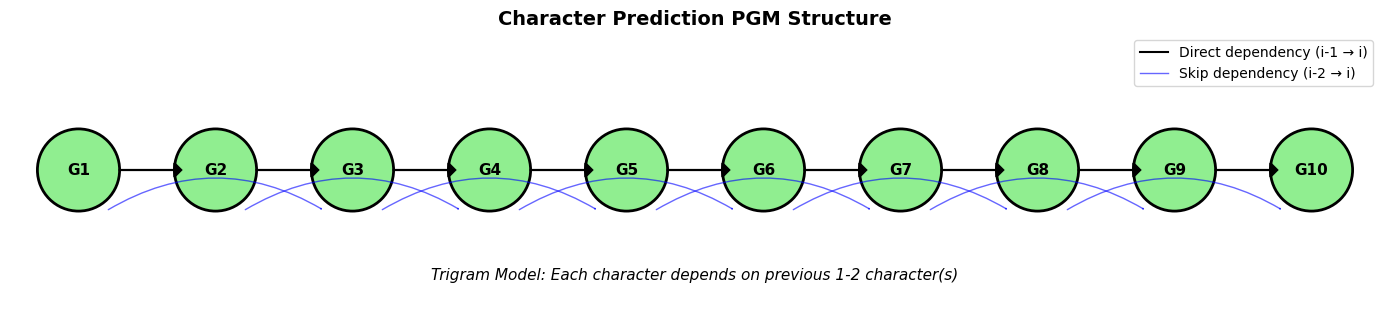


2. BUILDING LANGUAGE MODEL
----------------------------------------
Loading training data and building n-gram model...
Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 4019 entries
Wordlike model built with 4019 training words

3. RUNNING CHARACTER INFERENCE
----------------------------------------
Observed characters: {'G1': 21, 'G2': 4, 'G3': 6}
Predicted password: vegatereee
Actual password:    vegetable


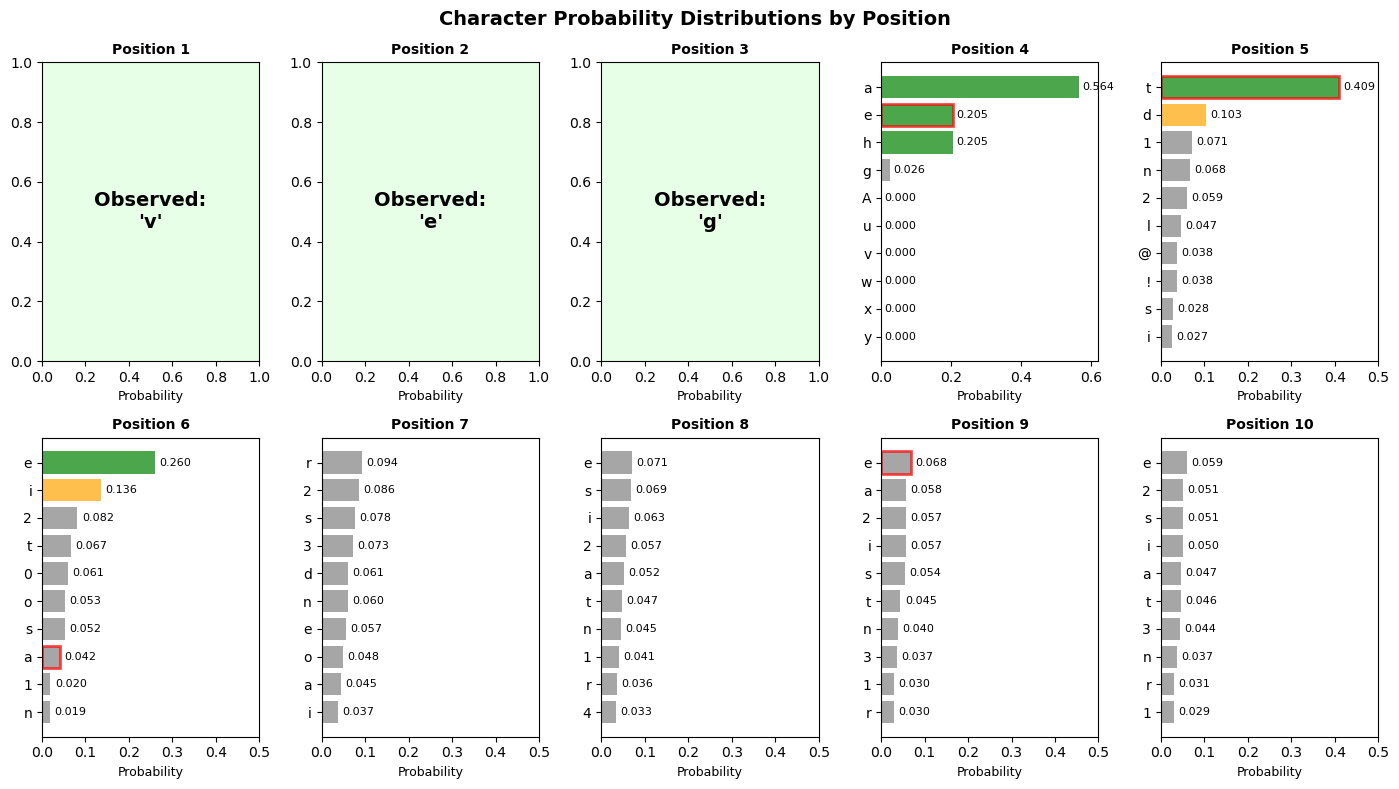

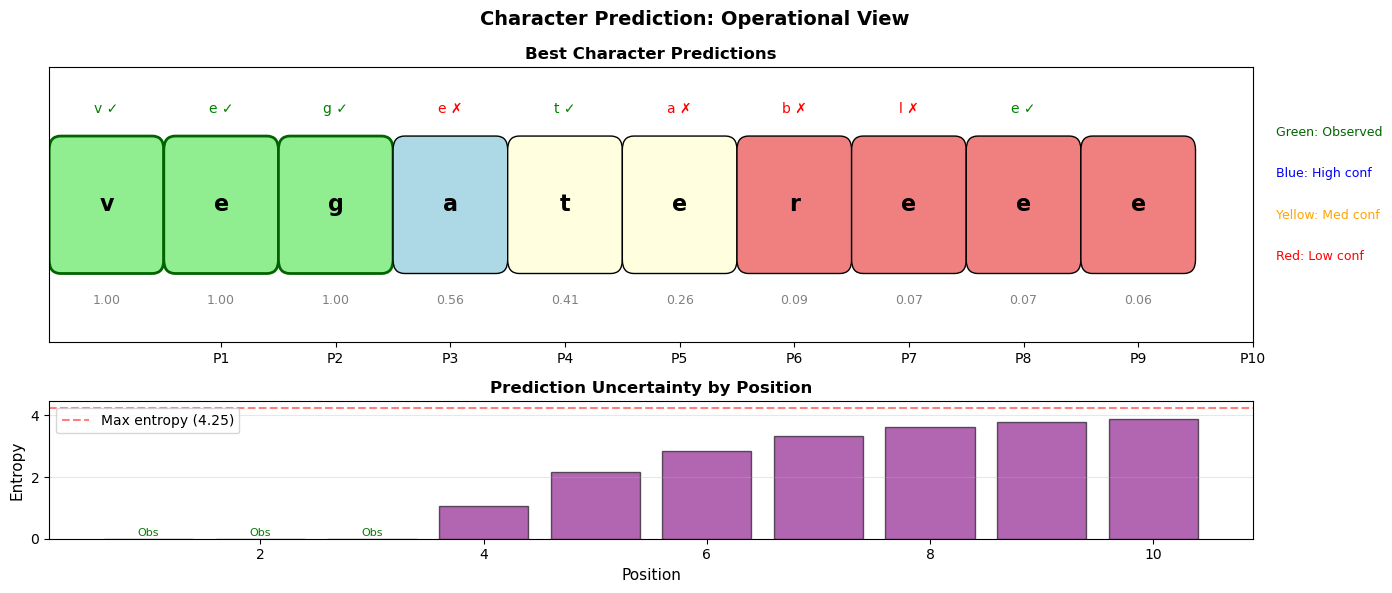


4. CHARACTER PREDICTION SUMMARY
----------------------------------------

Top 3 predictions per position:
Position 4: a(0.56), e(0.21), h(0.21)
Position 5: t(0.41), d(0.10), 1(0.07)
Position 6: e(0.26), i(0.14), 2(0.08)
Position 7: r(0.09), 2(0.09), s(0.08)
Position 8: e(0.07), s(0.07), i(0.06)
Position 9: e(0.07), a(0.06), 2(0.06)

Character accuracy: 5/9 = 55.56%

Key insight: Language patterns help predict likely characters,
but can be wrong without additional information!


In [2]:
# ============================================================================
# PART 2: CHARACTER PREDICTION (WORDLIKE) ATTACK
# ============================================================================

print("\n" + "=" * 70)
print("PART 2: CHARACTER PREDICTION ATTACK")
print("=" * 70)
print("\nUsing language patterns to predict password characters")
print("-" * 70)

# Import character prediction components
from wordlike_model import (
    build_wordlike_model,
    run_wordlike_inference,
    suggest_wordlike_guess,
    get_top_k_predictions,
    demo_wordlike_attack,
    CHARSET_INDEX
)
from wordlike_plot import (
    plot_wordlike_pgm_structure,
    plot_wordlike_posteriors,
    plot_wordlike_operational,
    plot_ngram_analysis
)

# Set target for character prediction
target_word = "vegetable"
known_prefix = "veg"
print(f"\nTarget password: {target_word}")
print(f"Known prefix: {known_prefix}")

# Step 1: Show PGM Structure
print("\n1. CHARACTER PREDICTION PGM STRUCTURE")
print("-" * 40)
print("Model structure: G_i-1 → G_i (with optional G_i-2 → G_i)")
print("- G_i ∈ CHARSET: Character at position i")
print("- Uses n-gram language patterns from training data")

fig = plot_wordlike_pgm_structure(use_ngrams=True, figsize=(14, 4))
plt.show()

# Step 2: Build Model and Analyze Training Data
print("\n2. BUILDING LANGUAGE MODEL")
print("-" * 40)
print("Loading training data and building n-gram model...")

# Build model (this will load the large dataset)
model_wordlike = build_wordlike_model(use_ngrams=True)

# Optional: Show n-gram analysis of training data
# Commented out for performance - uncomment to see training data patterns
# from common_words import get_training_words
# training_words = get_training_words(source="hybrid", limit=1000)
# fig = plot_ngram_analysis(training_words, n=3, top_k=20, figsize=(14, 6))
# plt.show()

# Step 3: Run Character Prediction
print("\n3. RUNNING CHARACTER INFERENCE")
print("-" * 40)

# Set up observed characters
observed_chars = {}
for i, char in enumerate(known_prefix):
    observed_chars[f"G{i+1}"] = CHARSET_INDEX[char]

print(f"Observed characters: {observed_chars}")

# Run inference
posteriors_wordlike = run_wordlike_inference(model_wordlike, observed_chars)
guess_wordlike = suggest_wordlike_guess(posteriors_wordlike, observed_chars)
top_predictions = get_top_k_predictions(posteriors_wordlike, k=3)

print(f"Predicted password: {guess_wordlike}")
print(f"Actual password:    {target_word}")

# Show character probabilities
fig = plot_wordlike_posteriors(posteriors_wordlike, 
                              observed=observed_chars,
                              target=target_word,
                              figsize=(14, 8))
plt.show()

# Show operational view
fig = plot_wordlike_operational(posteriors_wordlike,
                               observed=observed_chars,
                               target=target_word,
                               figsize=(14, 6))
plt.show()

# Step 4: Character Prediction Summary
print("\n4. CHARACTER PREDICTION SUMMARY")
print("-" * 40)

print("\nTop 3 predictions per position:")
for pos in range(len(known_prefix) + 1, min(len(target_word) + 1, 11)):
    if pos in top_predictions:
        preds = top_predictions[pos]
        print(f"Position {pos}: {', '.join([f'{c}({p:.2f})' for c, p in preds])}")

accuracy = sum(1 for i in range(len(guess_wordlike)) 
              if i < len(target_word) and guess_wordlike[i] == target_word[i])
print(f"\nCharacter accuracy: {accuracy}/{len(target_word)} = {accuracy/len(target_word):.2%}")
print("\nKey insight: Language patterns help predict likely characters,")
print("but can be wrong without additional information!")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from timing_model import (
    collect_timing_data,
    bin_timing_measurements,
    build_timing_model,
    run_timing_inference,
    suggest_binary_guess
)

from wordlike_model import (
    CHARSET_INDEX,
    build_wordlike_model,
    run_wordlike_inference,
    suggest_wordlike_guess,
    get_top_k_predictions
)

from hybrid_model import (
    build_hybrid_model,
    collect_hybrid_timing_data,
    run_hybrid_inference,
    suggest_hybrid_guess,
    get_hybrid_analysis
)

from hybrid_plot import plot_attack_comparison



PART 3: HYBRID ATTACK (COMBINING BOTH METHODS)

Leveraging both timing and character information for superior results
----------------------------------------------------------------------

Target password: vegetable
Known prefix: veg

1. HYBRID MODEL PGM STRUCTURE
----------------------------------------
Model structure: G_i → C_i → T_i with G_i-1 → G_i
- G_i ∈ CHARSET: Character at position i
- C_i ∈ {0,1}: Correctness at position i
- T_i ∈ {0,1,2}: Timing observation

Combines both information sources in unified model!


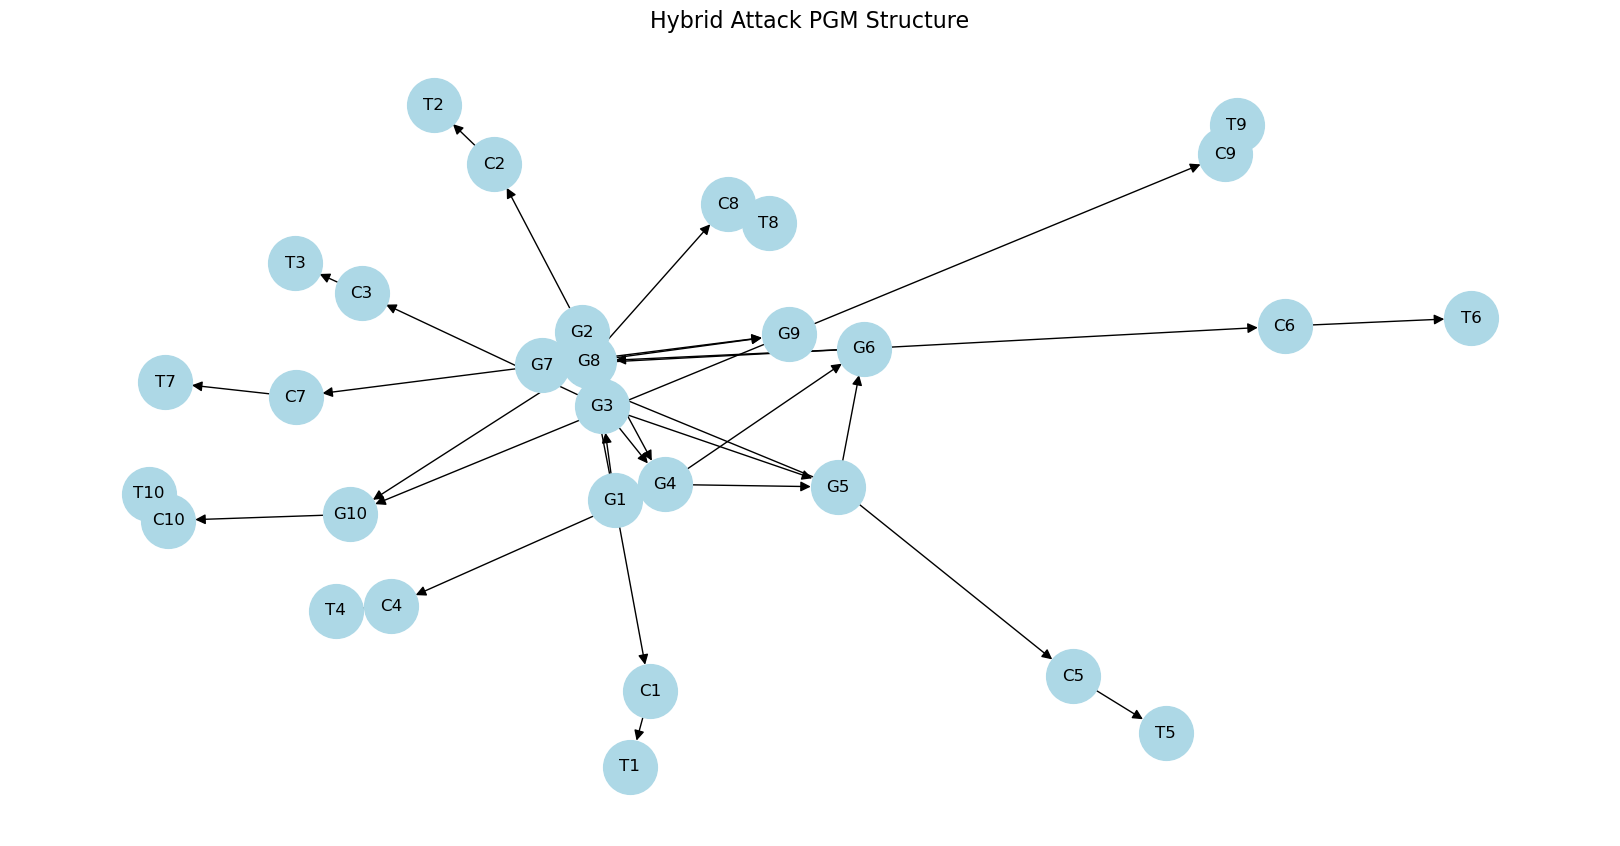


2. BUILDING HYBRID MODEL
----------------------------------------
Creating model with both character and timing components...
Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 4001 entries
Hybrid model built with 4001 training words

3. COLLECTING HYBRID EVIDENCE
----------------------------------------
Observed prefix: veg
Timing classes: [2, 2, 2, 2, 2, 2, 2, 0, 0, 0]
(0=short, 1=medium, 2=long)

4. RUNNING HYBRID INFERENCE
----------------------------------------
Hybrid prediction: vegatabaae
Actual password:   vegetable


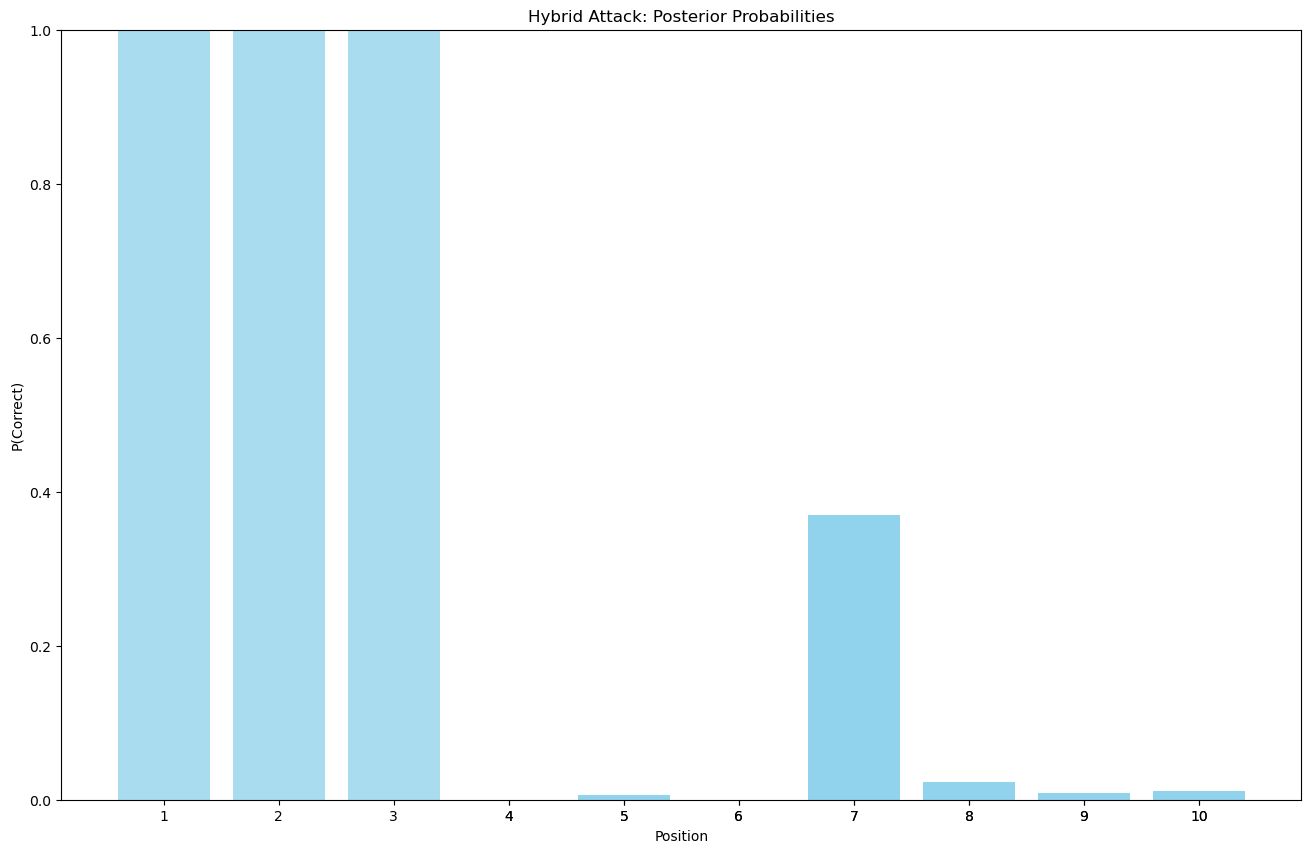

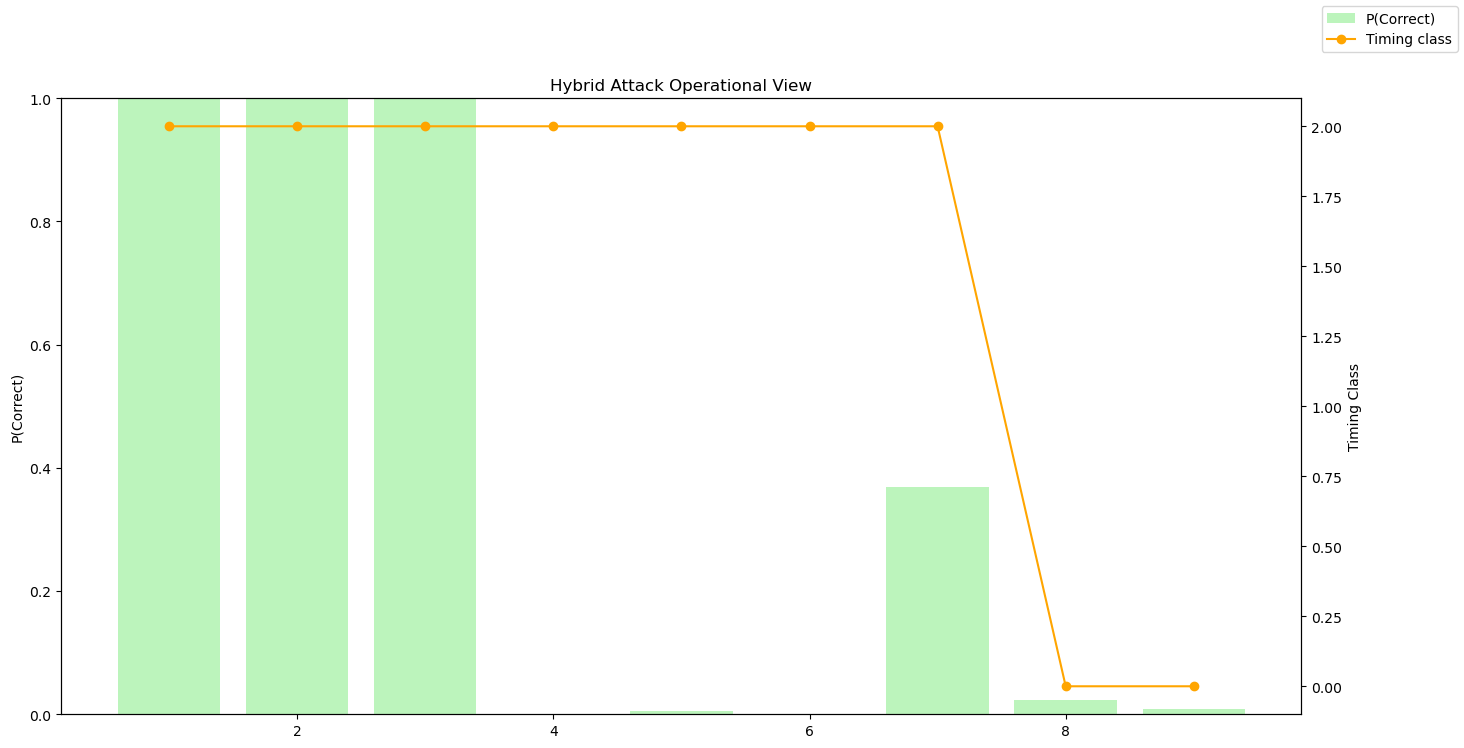


5. HYBRID ATTACK SUMMARY
----------------------------------------

Per-position analysis:
Pos | Char | P(Correct) | Confidence | Combined
--------------------------------------------------
  1 |  v   |   1.000    |   1.000    | 1.000 | v ✓
  2 |  e   |   1.000    |   1.000    | 1.000 | e ✓
  3 |  g   |   1.000    |   1.000    | 1.000 | g ✓
  4 |  a   |   0.040    |   0.941    | 0.037 | e ✗
  5 |  t   |   0.919    |   0.919    | 0.844 | t ✓
  6 |  a   |   0.661    |   0.661    | 0.437 | a ✓
  7 |  b   |   0.369    |   0.369    | 0.137 | b ✓
  8 |  a   |   0.002    |   0.119    | 0.000 | l ✗
  9 |  a   |   0.006    |   0.084    | 0.001 | e ✗
 10 |  e   |   0.018    |   0.080    | 0.001 | - ✗

Hybrid accuracy: 6/9 = 66.67%
Average confidence: 0.617
Average P(correct): 0.501


In [3]:
# ============================================================================
# PART 3: HYBRID ATTACK
# ============================================================================

print("\n" + "=" * 70)
print("PART 3: HYBRID ATTACK (COMBINING BOTH METHODS)")
print("=" * 70)
print("\nLeveraging both timing and character information for superior results")
print("-" * 70)

# Import hybrid components
from hybrid_model import (
    build_hybrid_model,
    run_hybrid_inference,
    suggest_hybrid_guess,
    collect_hybrid_timing_data,
    get_hybrid_analysis,
    demo_hybrid_attack
)
from hybrid_plot import (
    plot_hybrid_pgm_structure,
    plot_hybrid_posteriors,
    plot_hybrid_operational,
    plot_attack_comparison
)

# Set target for hybrid attack
hybrid_target = "vegetable"
hybrid_known = "veg"
print(f"\nTarget password: {hybrid_target}")
print(f"Known prefix: {hybrid_known}")

# Step 1: Show Hybrid PGM Structure
print("\n1. HYBRID MODEL PGM STRUCTURE")
print("-" * 40)
print("Model structure: G_i → C_i → T_i with G_i-1 → G_i")
print("- G_i ∈ CHARSET: Character at position i")
print("- C_i ∈ {0,1}: Correctness at position i")
print("- T_i ∈ {0,1,2}: Timing observation")
print("\nCombines both information sources in unified model!")

fig = plot_hybrid_pgm_structure(use_ngrams=True, figsize=(16, 8))
plt.show()

# Step 2: Build Hybrid Model
print("\n2. BUILDING HYBRID MODEL")
print("-" * 40)
print("Creating model with both character and timing components...")

model_hybrid = build_hybrid_model(use_ngrams=True, target_password=hybrid_target)

# Step 3: Collect Hybrid Evidence
print("\n3. COLLECTING HYBRID EVIDENCE")
print("-" * 40)

# Set up observed characters
observed_hybrid = {}
for i, char in enumerate(hybrid_known):
    observed_hybrid[f"G{i+1}"] = CHARSET_INDEX[char]

# Simulate timing data for hybrid attack
timing_data = collect_hybrid_timing_data(hybrid_known, hybrid_target)
timing_classes_hybrid = bin_timing_measurements(timing_data)

print(f"Observed prefix: {hybrid_known}")
print(f"Timing classes: {timing_classes_hybrid}")
print("(0=short, 1=medium, 2=long)")

# Step 4: Run Hybrid Inference
print("\n4. RUNNING HYBRID INFERENCE")
print("-" * 40)

posteriors_hybrid = run_hybrid_inference(model_hybrid, 
                                        observed_hybrid, 
                                        timing_classes_hybrid)
guess_hybrid, correctness = suggest_hybrid_guess(posteriors_hybrid, observed_hybrid)
analysis = get_hybrid_analysis(posteriors_hybrid, observed_hybrid)

print(f"Hybrid prediction: {guess_hybrid}")
print(f"Actual password:   {hybrid_target}")

# Show hybrid posteriors
fig = plot_hybrid_posteriors(posteriors_hybrid,
                            observed_chars=observed_hybrid,
                            timing_classes=timing_classes_hybrid,
                            target=hybrid_target,
                            figsize=(16, 10))
plt.show()

# Show hybrid operational view
fig = plot_hybrid_operational(posteriors_hybrid,
                             observed_chars=observed_hybrid,
                             timing_classes=timing_classes_hybrid,
                             target=hybrid_target,
                             figsize=(16, 8))
plt.show()

# Step 5: Hybrid Attack Summary
print("\n5. HYBRID ATTACK SUMMARY")
print("-" * 40)

print("\nPer-position analysis:")
print("Pos | Char | P(Correct) | Confidence | Combined")
print("-" * 50)
for i in range(10):
    char = guess_hybrid[i] if i < len(guess_hybrid) else '?'
    p_correct = correctness[i]
    confidence = analysis['confidence_scores'][i]
    combined = p_correct * confidence
    actual = hybrid_target[i] if i < len(hybrid_target) else '-'
    match = '✓' if char == actual else '✗'
    print(f" {i+1:2d} |  {char}   |   {p_correct:.3f}    |   {confidence:.3f}    | {combined:.3f} | {actual} {match}")

accuracy_hybrid = sum(1 for i in range(min(len(guess_hybrid), len(hybrid_target)))
                     if guess_hybrid[i] == hybrid_target[i])
print(f"\nHybrid accuracy: {accuracy_hybrid}/{len(hybrid_target)} = {accuracy_hybrid/len(hybrid_target):.2%}")
print(f"Average confidence: {np.mean(analysis['confidence_scores']):.3f}")
print(f"Average P(correct): {np.mean(correctness):.3f}")


PART 4: COMPARING ALL THREE ATTACK METHODS

Target for comparison: hunter2
Known prefix: hun
----------------------------------------------------------------------

1. TIMING ATTACK ONLY
Binary result: 1111111000
Avg P(correct): 0.560

2. CHARACTER PREDICTION ONLY
Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 4001 entries
Wordlike model built with 4001 training words
Character result: huntenieee
Character accuracy: 5/7 = 71.43%

3. HYBRID ATTACK
Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 4001 entries
Hybrid model built with 4001 training words
Hybrid result: hunterse3e
Hybrid accuracy: 6/7 = 85.71%

4. VISUAL COMPARISON


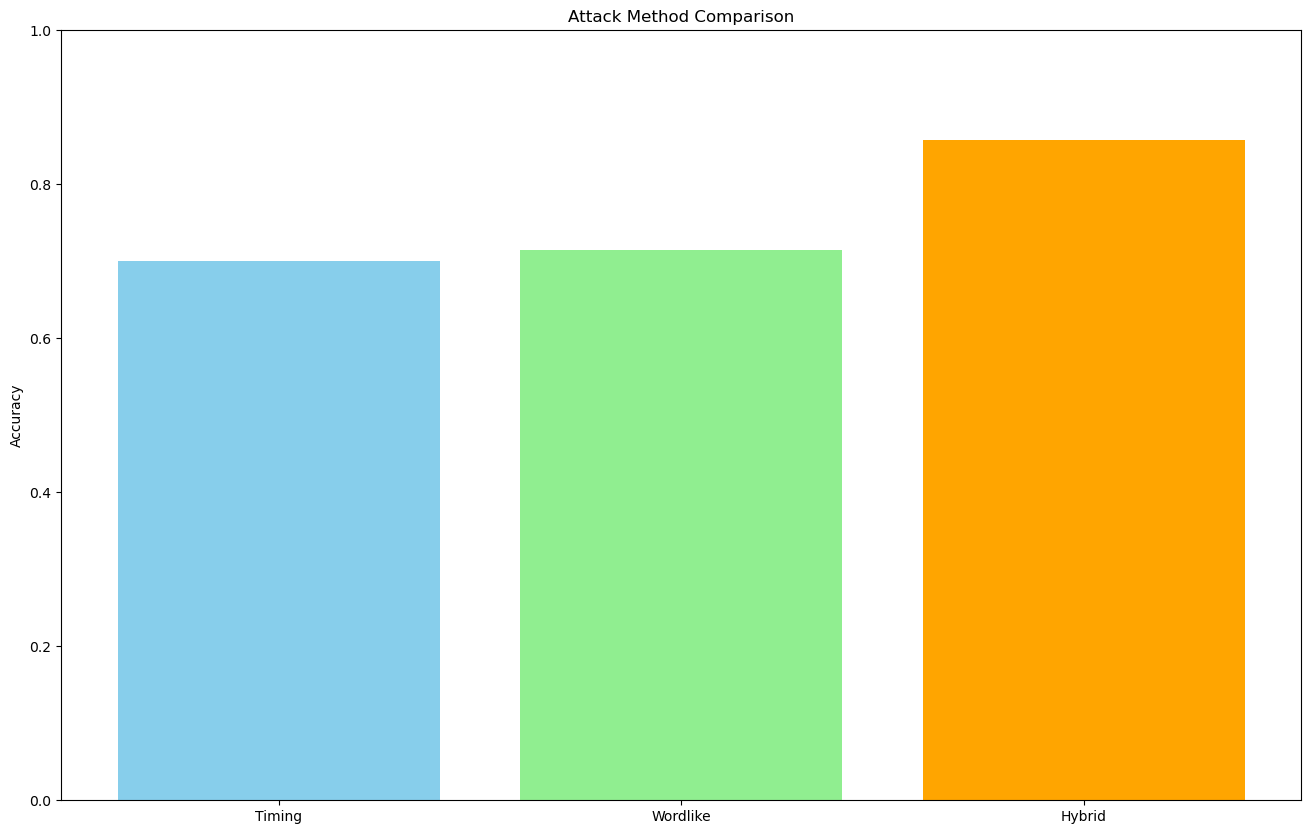

In [4]:
# ============================================================================
# PART 4: METHOD COMPARISON
# ============================================================================

print("\n" + "=" * 70)
print("PART 4: COMPARING ALL THREE ATTACK METHODS")
print("=" * 70)

# Run all three attacks on the same target for comparison
comparison_target = "hunter2"
comparison_known = "hun"

print(f"\nTarget for comparison: {comparison_target}")
print(f"Known prefix: {comparison_known}")
print("-" * 70)

# Timing attack
print("\n1. TIMING ATTACK ONLY")
timings_comp = collect_timing_data(comparison_target)
timing_classes_comp = bin_timing_measurements(timings_comp)
model_timing_comp = build_timing_model()
posteriors_timing_comp = run_timing_inference(model_timing_comp, timing_classes_comp)
binary_guess_comp = suggest_binary_guess(posteriors_timing_comp)
timing_probs_comp = [posteriors_timing_comp[f"G{i}"].values[1] 
                     for i in range(1, 11) if f"G{i}" in posteriors_timing_comp]

print(f"Binary result: {binary_guess_comp}")
print(f"Avg P(correct): {np.mean(timing_probs_comp):.3f}")

# Character prediction
print("\n2. CHARACTER PREDICTION ONLY")
observed_comp = {f"G{i+1}": CHARSET_INDEX[c] for i, c in enumerate(comparison_known)}
model_char_comp = build_wordlike_model(use_ngrams=True)
posteriors_char_comp = run_wordlike_inference(model_char_comp, observed_comp)
guess_char_comp = suggest_wordlike_guess(posteriors_char_comp, observed_comp)
top_pred_comp = get_top_k_predictions(posteriors_char_comp, k=3)

print(f"Character result: {guess_char_comp}")
accuracy_char = sum(1 for i in range(min(len(guess_char_comp), len(comparison_target)))
                    if guess_char_comp[i] == comparison_target[i])
print(f"Character accuracy: {accuracy_char}/{len(comparison_target)} = {accuracy_char/len(comparison_target):.2%}")

# Hybrid attack
print("\n3. HYBRID ATTACK")
model_hybrid_comp = build_hybrid_model(use_ngrams=True, target_password=comparison_target)
timing_hybrid_comp = collect_hybrid_timing_data(comparison_known, comparison_target)
timing_classes_hybrid_comp = bin_timing_measurements(timing_hybrid_comp)
posteriors_hybrid_comp = run_hybrid_inference(model_hybrid_comp, 
                                             observed_comp,
                                             timing_classes_hybrid_comp)
guess_hybrid_comp, correctness_comp = suggest_hybrid_guess(posteriors_hybrid_comp, observed_comp)
analysis_comp = get_hybrid_analysis(posteriors_hybrid_comp, observed_comp)

print(f"Hybrid result: {guess_hybrid_comp}")
accuracy_hybrid_comp = sum(1 for i in range(min(len(guess_hybrid_comp), len(comparison_target)))
                          if guess_hybrid_comp[i] == comparison_target[i])
print(f"Hybrid accuracy: {accuracy_hybrid_comp}/{len(comparison_target)} = {accuracy_hybrid_comp/len(comparison_target):.2%}")

# Visual comparison
print("\n4. VISUAL COMPARISON")
fig = plot_attack_comparison(
    timing_results=(posteriors_timing_comp, binary_guess_comp, timing_probs_comp),
    wordlike_results=(posteriors_char_comp, guess_char_comp, top_pred_comp),
    hybrid_results=(posteriors_hybrid_comp, guess_hybrid_comp, analysis_comp),
    target=comparison_target,
    figsize=(16, 10)
)
plt.show()